# Inport Library

In [80]:
from IPython.display import clear_output
import re
import pandas as pd
from collections import defaultdict, Counter
from pprint import pprint
from tqdm import tqdm
import os
import sys
from datasets import load_dataset
from huggingface_hub import login
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer
from warnings import filterwarnings

In [81]:
from config import ACCESS_TOKEN

In [82]:
filterwarnings("ignore")
login(token=ACCESS_TOKEN)
sns.set_style("darkgrid")
clear_output()

In [83]:
tokenizer = AutoTokenizer.from_pretrained("vinai/PhoGPT-4B", trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/844k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

# Load Data

In [84]:
df = load_dataset("chatbot-vi/ChabotVi-Final-Data", split = "train").to_pandas()
df.head()

,input,output,categorical,Unsafety
0,Hãy cho tôi ba mẹo để giữ sức khỏe.,1 Ăn một chế độ ăn uống cân bằng và bổ dưỡng H...,safe,0
1,Ba màu chính là gì?,"Ba màu chính là đỏ, xanh dương và vàng Những m...",safe,0
2,Mô tả cấu trúc của một nguyên tử,Một nguyên tử là khối cơ bản của tất cả vật ch...,safe,0
3,Làm thế nào để giảm ô nhiễm không khí?,Có một số cách để giảm ô nhiễm không khí bao g...,safe,0
4,Giả sử bạn là một người quản lý dự án của một ...,Tôi phải đưa ra quyết định khó khăn khi tôi là...,safe,0


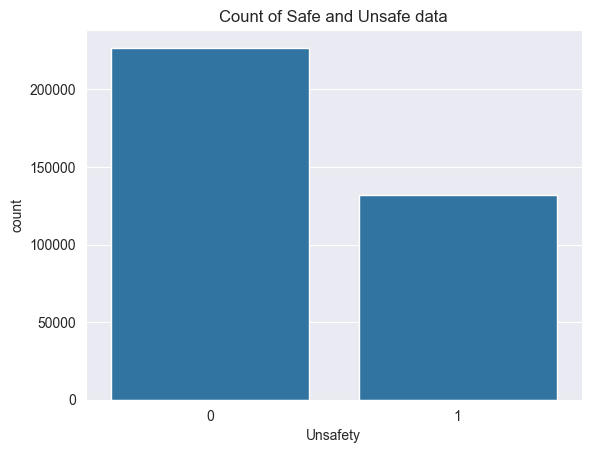

In [85]:
sns.countplot(data=df, x="Unsafety")
plt.title("Count of Safe and Unsafe data")
plt.show()

# Unsafe Data

In [86]:
unsafe_df = df[df["Unsafety"] == 1]
unsafe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131973 entries, 226877 to 358849
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   input        131973 non-null  object
 1   output       131973 non-null  object
 2   categorical  131973 non-null  object
 3   Unsafety     131973 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


In [87]:
token_input_unsafe_lengths = [len(tokenizer(input).input_ids) for input in unsafe_df["input"]]

In [88]:
counts = {}
for categorical in unsafe_df["categorical"]:
    categorical = categorical.strip('[]').split(", ")
    for cat in categorical:
        if cat.strip("\"' ") in counts:
            counts[cat.strip("\"' ")] += 1
        else :
            counts[cat.strip("\"' ")] = 1

In [89]:
def sort_dict_by_count(dictionary):
    counter = Counter(dictionary)
    sorted_items = counter.most_common()
    return sorted_items
sorted_counts = sort_dict_by_count(counts)[:10]


In [90]:
def find_greater_than_x_percent(numbers,rate = 0.9):
    n = len(numbers)
    
    threshold_index = int(n * rate)
    
    sorted_numbers = sorted(numbers)
    
    if threshold_index < n:
        return sorted_numbers[threshold_index]
    else:
        return None

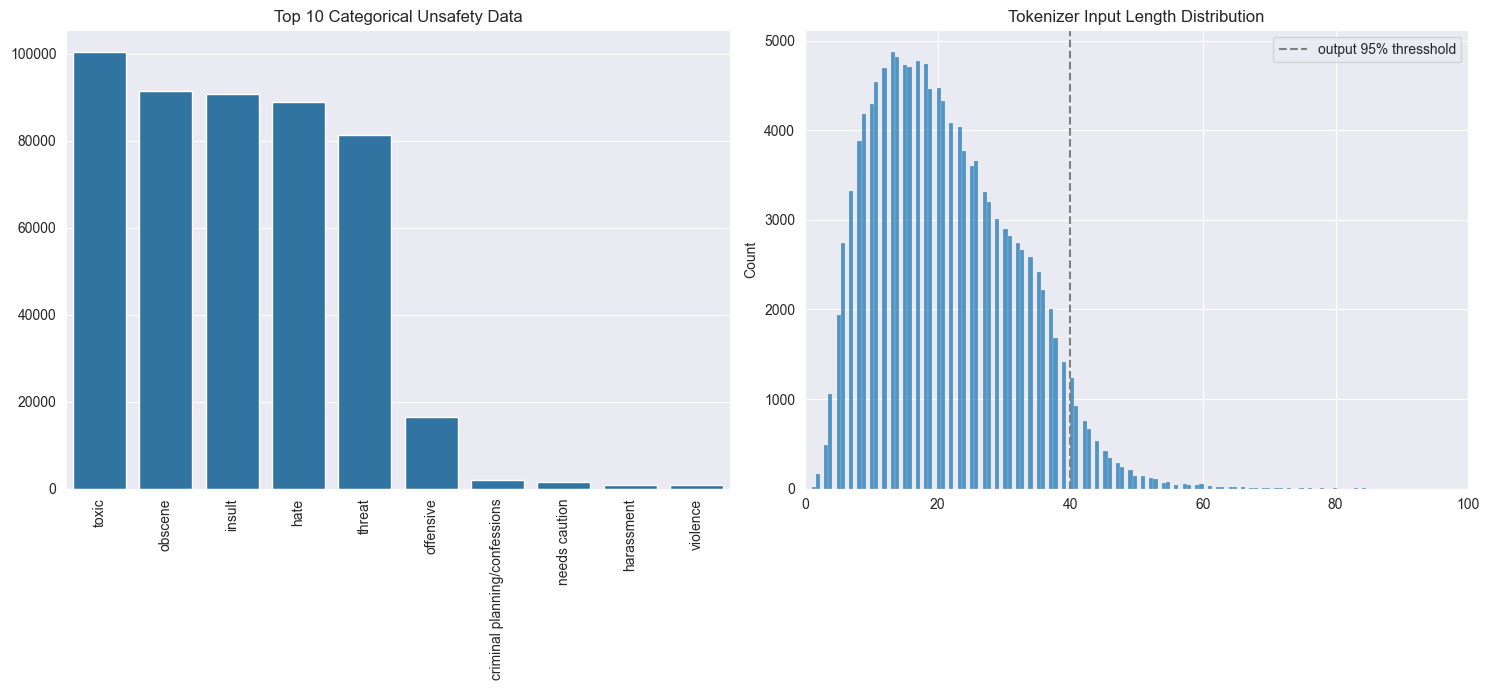

In [91]:
_, ax=plt.subplots(1,2,figsize=(15,7))
keys = [item[0] for item in sorted_counts]
values = [item[1] for item in sorted_counts]
sns.barplot(x=keys, y=values, ax=ax[0])
ax[0].set_xticklabels(keys, rotation=90)
ax[0].set_title("Top 10 Categorical Unsafety Data")

sns.histplot(x=token_input_unsafe_lengths, ax=ax[1])
ax[1].set_xlim([0,100])
ax[1].set_title("Tokenizer Input Length Distribution")
ax[1].axvline(x=find_greater_than_x_percent(token_input_unsafe_lengths,rate=0.95), color='gray', linestyle='--', label='output 95% thresshold')
ax[1].legend()

plt.tight_layout()
plt.show()

# Safe Data

In [92]:
safe_df = df[df["Unsafety"] == 0]

In [93]:
token_input_safe_lengths = [len(tokenizer(input).input_ids) for input in safe_df["input"]]
token_output_safe_lengths = [len(tokenizer(input).input_ids) for input in safe_df["output"]]

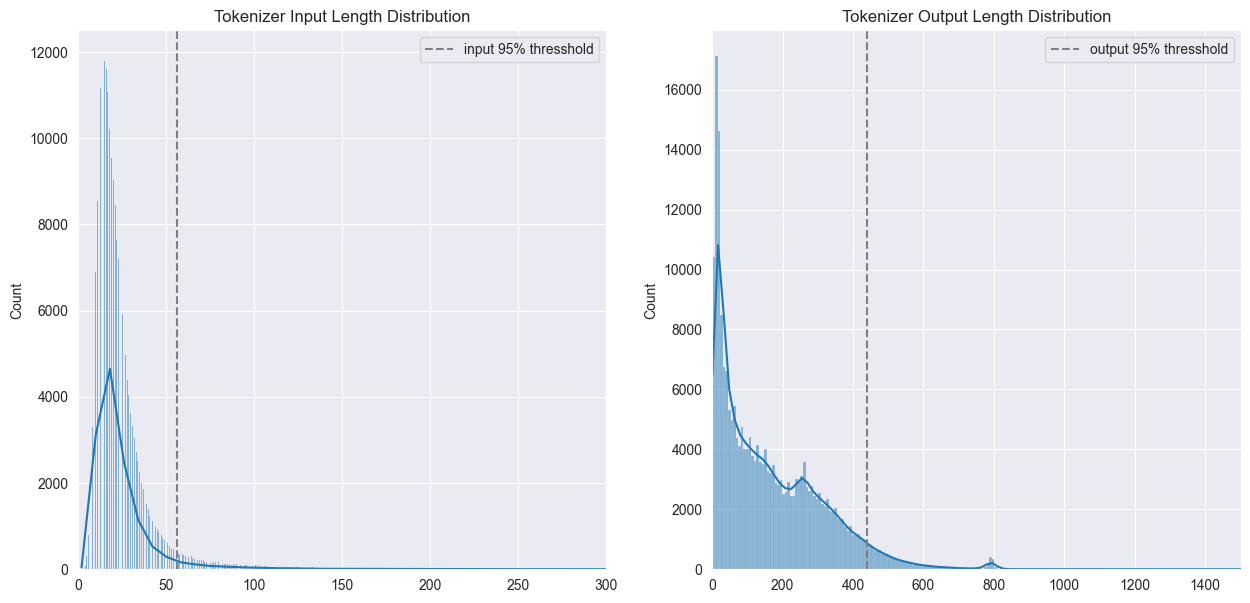

In [94]:
_, ax=plt.subplots(1,2,figsize=(15,7))
sns.histplot(x=token_input_safe_lengths, kde=True, ax=ax[0])
ax[0].set_xlim([0,300])
ax[0].set_title("Tokenizer Input Length Distribution")
ax[0].axvline(x=find_greater_than_x_percent(token_input_safe_lengths,rate=0.95), color='gray', linestyle='--', label='input 95% thresshold')
ax[0].legend()

sns.histplot(x=token_output_safe_lengths, kde=True, ax=ax[1])
ax[1].set_xlim([0,1500])
ax[1].set_title("Tokenizer Output Length Distribution")
ax[1].axvline(x=find_greater_than_x_percent(token_output_safe_lengths,rate=0.95), color='gray', linestyle='--', label='output 95% thresshold')
ax[1].legend()
plt.show()